# HW 3 Problem 2: Heavy vs. Light Tails

In [1]:
import numpy as np
from scipy import stats
from scipy.special import gamma
from sklearn import linear_model
import matplotlib.pyplot as plt
import heapq

n = 10000 # Arbitrary plotting value for large n

## Part a: Law of Large Numbers

The law of large numbers states that as the sample size increases, the sample mean approaches the population mean. This aligns with what we see in the first two, as we expect the cumulative sum to grow linearly (with some errors) with n to maintain the value of slope close to the population mean. The Pareto distribution doesn't look linear due to the "some errors" being extremely large because of infinite variance. 

In [81]:
def make_graph_a(
    # Function to make our plots look nice
    xs,
    ys,
    distribution="Standard Normal",
    xlabel="Number of Variable Draws (n)",
    ylabel="Cumulative Sum"):
    """
    xs: List of x values to plot
    ys: List of y values to plot
    distribution: The name of the distribution that you are plotting
    """
    title = "{0} of {1} Distribution".format(ylabel, distribution)
    
    plt.subplots(1, 2, figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(xs[:20], ys[:20])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title + " (First 20 values)")

    plt.subplot(1, 2, 2)
    plt.plot(xs, ys)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    plt.show()
    

In [97]:
normal_draws = np.random.normal(loc=1, scale=1, size=n)
weibull_draws = np.random.weibull(a=0.3, size=n)
pareto_draws = np.random.pareto(a=0.5, size=n) * (1 / 3)

# Draw plots
# Instead of simulating for i=1...10^5 trials, take a partial sum
x_range = np.linspace(1, n, num=n)
normal_cumsum = np.cumsum(normal_draws)
weibull_cumsum  = np.cumsum(weibull_draws)
pareto_cumsum = np.cumsum(pareto_draws)

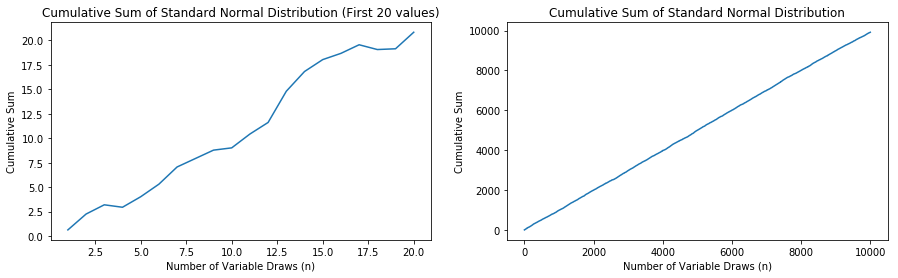

In [98]:
make_graph_a(
    x_range,
    normal_cumsum,
    distribution="Standard Normal")

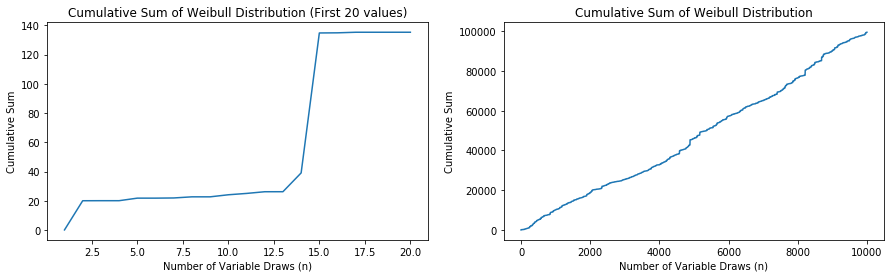

In [99]:
make_graph_a(
    x_range,
    weibull_cumsum,
    distribution="Weibull")

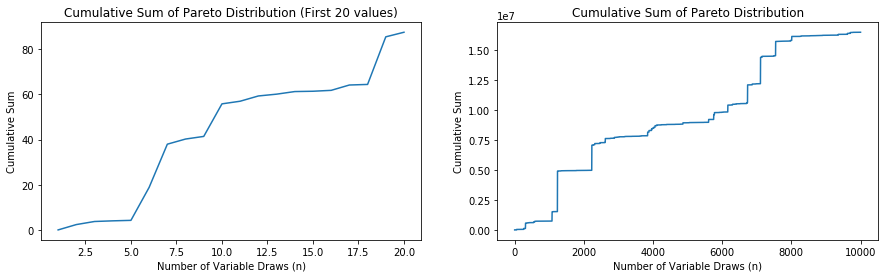

In [100]:
make_graph_a(
    x_range,
    pareto_cumsum,
    distribution="Pareto")

## Part b: Central Limit Theorem

The Central Limit Theorem tells us that deviations of $S_n$ from its mean are of size $\sqrt{n}$, or that $\frac{S_n − nE[X]}{\sqrt{n}}$ is a normal variable with mean 0 and the same variance as the distribution, as long as variance is finite. Our plots of $\frac{S_n − nE[X]}{\sqrt{n}}$ vs. $n$ for the normal and Weibull distributions align with the Central Limit Theorem, as we expect $\frac{S_n − nE[X]}{\sqrt{n}}$ to be a normal random variable centered at 0 and we see that the plots do fluctuate around 0. We are not testing the Pareto distribution here, because the Pareto distribution with alpha < 2 has infinite variance and we won't be able to observe the above behavior.

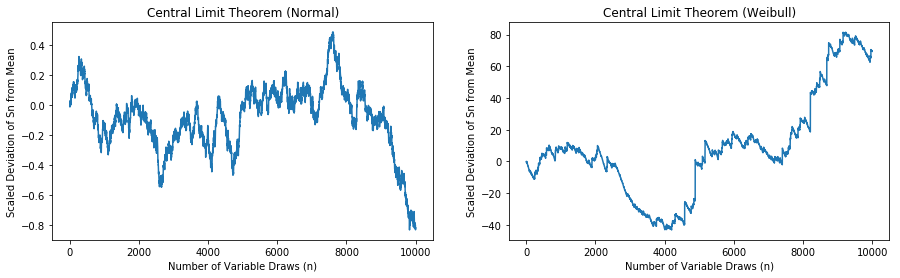

In [101]:
# Test the CLT by plotting the scaled deviation of Sn from its mean
normal_mean = 1
weibull_mean = gamma(1 + 1 / 0.3)
normal_clt = (normal_cumsum - np.linspace(1, n, num=n) * normal_mean) / (n ** (1 / 2))
weibull_clt = (weibull_cumsum - np.linspace(1, n, num=n) * weibull_mean) / (n ** (1 / 2))

# Once the above variables are defined, we can make our plots
plt.subplots(1, 2, figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(x_range, normal_clt)
plt.xlabel("Number of Variable Draws (n)")
plt.ylabel("Scaled Deviation of Sn from Mean")
plt.title("Central Limit Theorem (Normal)")

plt.subplot(1, 2, 2)
plt.plot(x_range, weibull_clt)
plt.xlabel("Number of Variable Draws (n)")
plt.ylabel("Scaled Deviation of Sn from Mean")
plt.title("Central Limit Theorem (Weibull)")
plt.show()

## Part c: The 80-20 rule

We can see from the plot that 80% of the wealth is held by about 7.5% of population according to the Weibull distribution, which is a bit more extreme than the 80-20 rule (more heavy-tailed). We see an even more extreme result for the Pareto distribution, as about 3% of the population owns almost all of the wealth (very close to 100%) and about 1% owns about 97% of the wealth, which highlights the heavy-tailed nature of the Pareto distribution. 

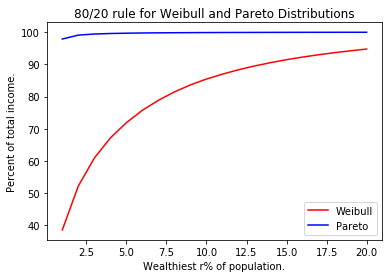

In [102]:
weibull_largest = [sum(heapq.nlargest(round(n * r / 100), weibull_draws)) for r in range(1, 21)] / sum(weibull_draws) * 100
pareto_largest = [sum(heapq.nlargest(round(n * r / 100), pareto_draws)) for r in range(1, 21)] / sum(pareto_draws) * 100

# Once the above lists are generated, we can make our plots
rRange = np.linspace(1, 20, num=20)

plt.plot(rRange, weibull_largest, 'r')
plt.plot(rRange, pareto_largest, 'b')
plt.xlabel("Wealthiest r% of population.")
plt.ylabel("Percent of total income.")
plt.title("80/20 rule for Weibull and Pareto Distributions")
plt.gca().legend(("Weibull", "Pareto"))
plt.show()

## Part d: Identifying Heavy Tails

Based on the frequency plots, it seems that both the Weibull and Pareto distributions are heavy-tailed as the shapes on the log-log scale are approximately linear, although the shape near the tail is unclear. Rank plots make it easier to identify heavy tails, as the rank plot of the Weibull distribution is not linear, while the rank plot of the Pareto distribution is approximately linear except the first couple points. Outliers were not removed from the rank plots, because it would simply truncate the plot (once the ranks are assigned, even the outliers have normal rank values, unlike frequency plot), not affecting the shape of the plot.

In [41]:
def pdf(data, dx=1):
    # Given a distribution's random samples, creates an approximate PDF of points
    # Returns a tuple of two vectors x, y where 
    #   y_i = P(x_i - dx/2 <= data < x_i + dx/2)
    
    low, high = np.min(data), np.max(data)
    x, y = [], []
    
    for d in data:
        i = int((d + dx / 2 - low) / dx)
        xi = low + i * dx
        if xi in x:
            y[x.index(xi)] += 1
        else:
            x.append(xi)
            y.append(1)
    
    return np.array(x), np.array(y)
    
def ccdf(data):
    # Given a distribution's random samples, creates an approximate CCDF of points
    # Returns a tuple of two vectors x, y where 
    #   y_i = P(data > x_i)
    return np.sort(data), np.linspace(1, 0, n)

def keep_positive(data):
    # Filters out negative and zero entries (in both x and y) in data
    
    for i in range(3):
        # Indicates which entries to keep
        bool_array = np.logical_and(data[i][0] > 0, data[i][1] > 0)
        
        data[i] = (data[i][0][bool_array], data[i][1][bool_array])
    
    return data
 
def non_outliers(x, m):
    # Returns a list of boolean values determining whether or not
    # an entry is a non-outlier (centered entry is within m std devs) of the set x
    return abs(x - np.mean(x)) <= m * np.std(x)
    
def reject_outliers(data, m=3):
    # Removes all outliers from a generated distribution
    # Note that since we are plotting on log-log scale
    # Removing outliers should happen AFTER we move to log-log scale
    
    bool_arr = non_outliers(data[0], m)
    return data[0][bool_arr], data[1][bool_arr]
    
def linear_regression(X, Y):
    # Fits the linear model y = mx + b
    # Returns the best-fit values of m and b as well as r^2 on given data
    X = X.reshape(-1, 1)
    reg = linear_model.LinearRegression().fit(X, Y)
    return reg.coef_, reg.intercept_, reg.score(X, Y)

def make_graphs_d(data, title, labels, ylabel='', xlabel=''):
    """
    Build respective PDF/CCDF for all three distributions
    Attempts to create a best-fit line
    And plots this line alongside the points
    data: List of pdf() outputs from all 3 distributions
    title: Either 
        Frequency plot (PDF)
        Rank plot (CCDF)
    labels: List of distribution names
        i.e. ["Normal, Weibull, Pareto"]
    """
    # General plotting function for points, as well as best-fit line
    
    for (X, Y), label in zip(data, labels):
        m, b, r2 = linear_regression(X, Y)
        plt.scatter(X, Y, label=label, s=1)
        plt.plot(X, b + m * X, label='y = %.2f * x + %.2f, r2 = %.3f' % (m, b, r2))
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.show()

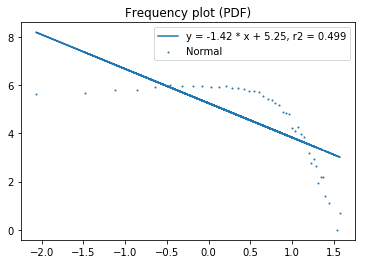

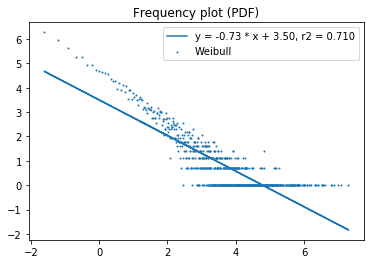

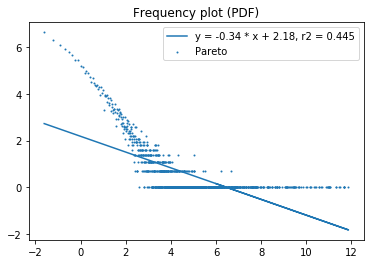

In [52]:
# Concatenate data into one list to reduce code repetition
Xi = [normal_draws, weibull_draws, pareto_draws]
names = ["Normal", "Weibull", "Pareto"]

# Build the PDF and turn it into a log-log scale,
# first removing all negative values and corresponding indices
data = [pdf(Xi[i], dx=0.1) for i in range(3)]
data = keep_positive(data)
data = [(np.log(X), np.log(Y)) for (X, Y) in data]
data = [reject_outliers(data[i], 3) for i in range(3)]

# Plot the frequencies
make_graphs_d(data, 'Frequency plot (PDF)', names)

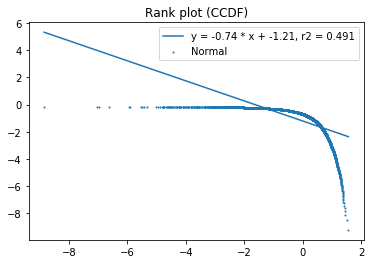

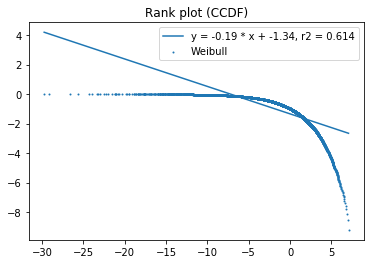

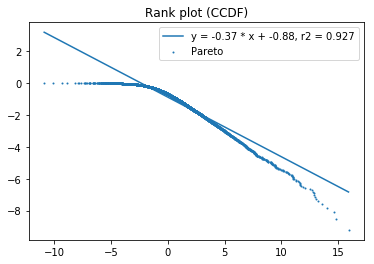

In [117]:
data = [ccdf(Xi[i]) for i in range(3)]

# Build the CCDF and turn it into a log-log scale,
# first removing all negative values and corresponding indices
data = keep_positive(data)
data = [(np.log(X), np.log(Y)) for (X, Y) in data]

# Removing outliers after ranks are assigned simply makes the plot shorter, which is meaningless

# Plot the ranks
make_graphs_d(data, 'Rank plot (CCDF)', names)